152


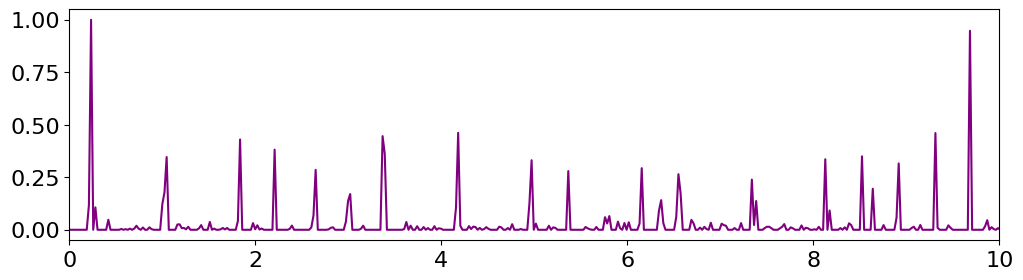

In [11]:
import numpy as np
from matplotlib import pyplot as plt
import librosa.display
from RhythmRecognition.constants import *
import matplotlib as mpl
from RhythmRecognition.onset import spectral
from RhythmRecognition.tempo import fourier
from RhythmRecognition.beat import score
from RhythmRecognition.beat.click_track import *
import IPython.display as ipd

mpl.rcParams.update({'font.size': 16})

audiofile = "../audio_files/valhallacalling.wav"
duration = 60  # how many seconds of the file will be processed

spectral_novelty = spectral.SpectralNovelty(audiofile, duration=duration)
spectral_novelty = spectral_novelty.get()

frames = np.arange(len(spectral_novelty))
t = librosa.frames_to_time(frames, sr=SAMPLING_RATE, hop_length=HOP_LENGTH)

fourier_tempo = fourier.FourierTempogram(spectral_novelty)
tempo = fourier_tempo.get_tempo()
print(tempo)

plt.figure(figsize=(12, 3))
plt.plot(t, spectral_novelty, 'purple')
plt.xlim(0,10)
plt.show()

In [12]:
beat_tracker = score.ScoreBeatTracker(spectral_novelty, tempo, duration)
shift = beat_tracker.get_time_shift()
print(shift)

0.213


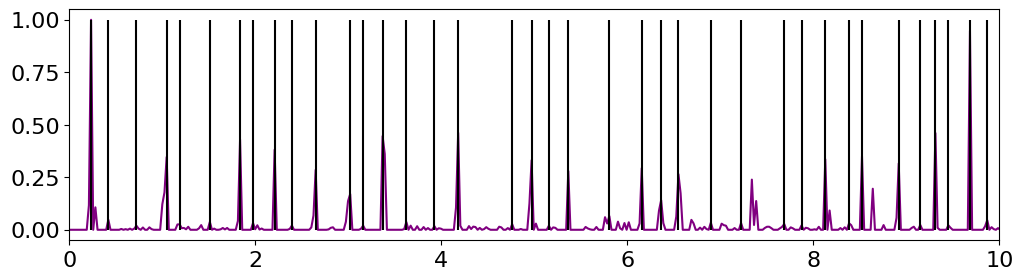

In [13]:

plt.figure(figsize=(12, 3))
plt.plot(t, spectral_novelty, 'purple')
plt.vlines(t[beat_tracker.peaks], 0, spectral_novelty.max(), color='black')
plt.xlim(0,10)
plt.show()

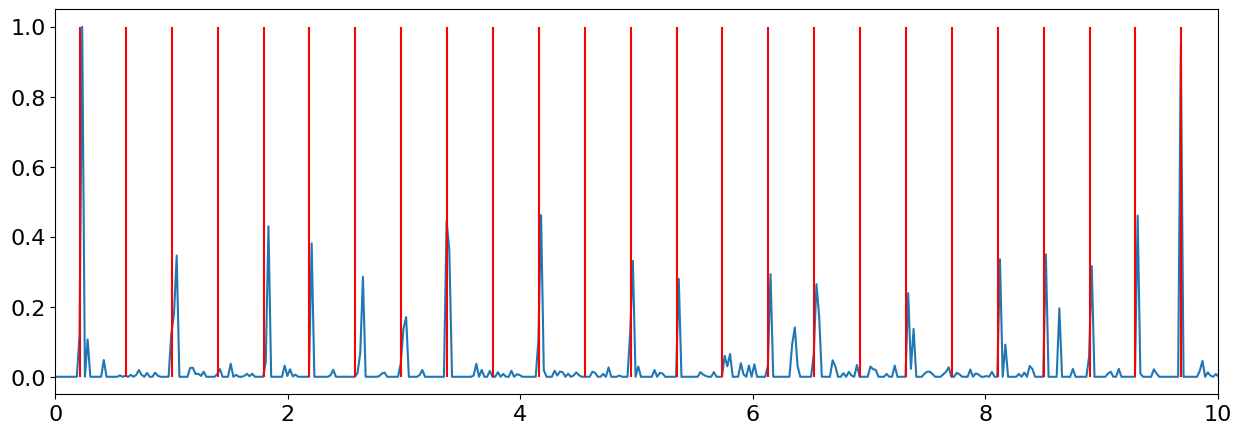

In [14]:
click_times = beat_tracker.click_times_sec

plt.figure(figsize=(15, 5))
plt.plot(t, spectral_novelty)
plt.vlines(np.array(click_times) + shift, 0, spectral_novelty.max(), color='red')
plt.xlim(0, 10)    
plt.show()

In [15]:
frames = librosa.time_to_frames(np.array(click_times) + shift, sr=SAMPLING_RATE, hop_length=HOP_LENGTH)

signal, sr = librosa.load(audiofile, duration=30, sr=SAMPLING_RATE)
click_track = librosa.clicks(frames=frames, sr=SAMPLING_RATE, length=len(signal), hop_length=HOP_LENGTH)
ipd.Audio(signal + click_track, rate=SAMPLING_RATE)